In [1]:
from pandas import read_csv
import numpy as np
from ucla.core.constants import *
from ucla.core.local_ODE_solver import LocalModel
from ucla.core.physics import SMT

import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

from average_atom.core.physics import More_TF_Zbar
eV_to_J = eV_to_AU*AU_to_J


### Argon based on Chris Fontes 

In [2]:
Te_eV = 1.5 #eV
nn_invcc = 6.2e20
Ar_nn_invcc = nn_invcc
Zbar = 6.92e-2
ne_invcc = Ar_nn_invcc*Zbar


In [3]:
element='Ar'

if element=='Ar':
    Z, A = 18, 39.948
    m_i = A*m_p
    mi_kg = m_i
    nn_invm3 = nn_invcc*1e6
    ne_invm3 = ne_invcc*1e6
    ρi_kginvm3 = m_i*nn_invm3
    ri = 1/(4/3*π*nn_invm3)**(1/3)*m_to_AU

    Zi_array = np.array([1, 2])
    
    Ti_K = 0
    Te_K = Te_eV*eV_to_K
    
    l0_n_invcm = np.array([93143.7653, 93750.6031, 94553.6705, 95399.8329, 104102.1043, 107054.2773, 105462.7649, 105617.2753, 
                          106087.2651, 106237.5571, 107131.7139, 107289.7054, 107496.4219, 108722.6247, 111667.771, 111818.033,
                          112138.929, 114147.737, 112750.158, 113020.360, 113425.969, 113716.560, 113468.478, 113643.265, 
                          114640.997, 114821.944, 114805.140, 115366.871, 114861.640, 114975.024]) # Excitation levels in 1/cm
    
    l0_n_invcm = np.array([93143.7653, 93750.6031, 94553.6705, 95399.8329, 104102.1043, 107054.2773, 105462.7649, 105617.2753, 
                          106087.2651, 106237.5571, 107131.7139, 107289.7054, 107496.4219, 108722.6247, 111667.771, 111818.033,
                          112138.929, 114147.737, 112750.158, 113020.360, 113425.969, 113716.560, 113468.478, 113643.265, 
                          114640.997, 114821.944, 114805.140, 115366.871, 114861.640, 114975.024]) # Excitation levels in 1/cm
    
    J_n        = np.array([2, 1, 0, 1, 1, 0, 3, 2, 1, 2, 1, 2, 1, 0, 0, 1, 2, 1, 4, 3, 2, 3, 2, 1, 2, 3, 2, 1, 0, 1])
    stat_weights = 2*J_n + 1
    
    χ0_eV = 15.7596119  # eV See 
    χ0_AU = χ0_eV*eV_to_AU  # eV See 
    χ0_J = χ0_eV*eV_to_J

    # ionization_file="../../data/Ar25bar_Saha.txt"
    saha_eos_file = "/home/zach/plasma/saha/data/Ar25bar_Saha.txt"
    element_data_file = "../../data/experimental_data/Ar_25bar_Te.txt"

    

#### Bound-Free Absorption

In [4]:
def Level_invcm_to_eV(l_invcm): # standard input is 1/wavelength for some reason
    λ_nm = 1/l_invcm * 1e7
    return λ_nm_to_Eγ(λ_nm)

def λ_nm_to_Eγ(λ_nm):
    λ_m = λ_nm*1e-9
    ν = c/λ_m
    ω = ν*2*π
    return ω*hbar*J_to_eV
    

def Eγ_to_λ_nm(Eγ):
    ω = Eγ/(hbar*J_to_eV)
    ν = ω/(2*π)
    
    λ_m = c/ν
    λ_nm = λ_m*1e9
    return λ_nm
    
    
def ω_invs_from_E_eV(Eγ_eV):
    return Eγ_eV*eV_to_J/hbar
    
# @np.vectorize
# def get_κbf_absorption_new(n0_invcc, Te_eV, Eγ_eV, x1 = Zbar): 
#     """
#     Obtained from Zel'dovich & Raizer Vol 1 
#     float n0_invcc: number density of neutral atoms (excited and ground) in 1/cm^3
#     float Eγ_eV: photon energy in eV
    
#     For number density of ion i, n_i, and ionization cross section for level n
#     E_n from NIST - https://physics.nist.gov/PhysRefData/Handbook/Tables/argontable6.htm
#     n_n = n_0 g_n/g_0 exp[-β χ1 (1 - 1/n^2) ] # Boltzmann exponent difference between hydrodgn-like excited and ground (no quantum distributoin?? Gaunt??)
#     ω_n = ω_invs_from_E_eV(χ1 Z^2/n^2) # I think Z=1 here... not entirely sure
#     σ_n_cm2 = 7.9e-18 * n/Z^2 (ωn/ω)^3 Θ(ω > ω_n) [cm^2]# I think Z=1 here... not entirely sure
#     κ_invm = sum_i n_n σ_n
#     """
#     Z = 1 # ??
    
#     E0_n_array = Level_invcm_to_eV(l0_n_invcm)  # Energy of nth excited state assuming Hydrogen-like and no continuum lowering
#     g0, g_n_array = 2, 2*stat_weights  # statistical weights for hydrogen-like
#     n_n_array = n0_invcc * g_n_array/g0 * np.exp(-1/Te_eV*(E0_n_array - χ0_eV )) # density of nth excited state
#     ω_n_array = ω_invs_from_E_eV( E0_n_array )
#     ω_invs = ω_invs_from_E_eV(Eγ_eV)
#     σ_n_array = 7.9e-18 * n_array/Z**2 * (ω_n_array/ω_invs)**3*np.heaviside(ω_invs - ω_n_array, 0.0) # cross-section for excitation of nth excited state to continuum (free) 
    
#     κ_invm = np.sum(n_n_array*σ_n_array)
#     return  κ_invm

# get_κbf_absorption_new(nn_invcc, Te_K*K_to_eV, 5 )

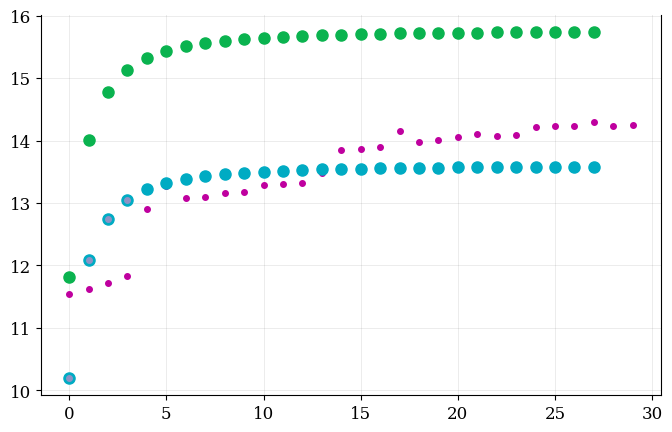

In [5]:
fig, ax = plt.subplots()

ax.plot(Level_invcm_to_eV(127109.842	) - Level_invcm_to_eV(127109.842)/np.arange(2,30)[::1]**2, 'o')
ax.plot(Level_invcm_to_eV(l0_n_invcm), '.' )
ax.plot(Level_invcm_to_eV(109678.7717) - Level_invcm_to_eV(109678.7717)/np.arange(2,30)[::1]**2, 'o')
ax.plot(Level_invcm_to_eV(np.array([ 82258.9191, 97492.2217, 102823.8486,  105291.6287])), '.')

#### Free-Free Absorption

In [6]:
def get_κff_absorption(Eγ_eV, Zbar):
    ω_invs = Eγ_eV*eV_to_J/hbar
    κ_invm = SMT.photon_absorption_coefficient(ω_invs, mi_kg, Zbar*nn_invm3, Zbar*nn_invm3, Ti_K, Te_K)
    return κ_invm

# def get_κff_absorption_new(Eγ_eV, x1 = Zbar): 
#     """
#     γ = ne/nc
#     νei = 2.91e-12*Te_eV**-1.5 * Σ_i( Z_i**2 n_i lnΛ_i)
#     Λ_i(D&D) = ln( 1 + 0.7* λDe_AU Te_AU/Z ) 
#     κ_invm = νei γ/c /sqrt(1-γ) fl fsc
#     """
#     xi_array = np.array([ x1, (Zbar - x1)/2 ])
#     ni_invm3_array = nn_invm3 * xi_array * Zi_array

#     ω_invs = Eγ_eV*eV_to_J/hbar
#     ωpe = SMT.electron_plasma_frequency(ne_invm3)
#     γ = (ωpe/ω_invs)**2 # γ = ne/nc = ωpe^2/ω^2
#     λDe = SMT.electron_thermal_velocity(Te_eV*eV_to_K)/np.sqrt(3)/ωpe # they define without sqrt(3) 
#     lnΛi = np.log( 1 + 0.7 * λDe*m_to_AU * Te_eV*eV_to_AU/Zi_array)
#     νei =  2.91e-12*Te_eV**-1.5 * np.sum( Zi_array**2 * ni_invm3_array * lnΛi  ) 
#     κ_invm = νei * γ/c/np.sqrt( 1 - γ)
#     return κ_invm

# get_κff_absorption_new(1)

In [7]:
"opac_ar_1.5ev_1.5ev_6.2e20cc_01_03_CL_5000pts_log_contribs_zoom_total"

'opac_ar_1.5ev_1.5ev_6.2e20cc_01_03_CL_5000pts_log_contribs_zoom_total'

In [8]:
CF_dir = "/home/zach/plasma/ucla/data/CF_Collisional_Radiative/"
Ar_type_dir = "Ar_Te=Tr=1.5eV_nAr=6.2e20invcc"
file_basename = "/opac_ar_1.5ev_1.5ev_6.2e20cc_01_03_CL_5000pts_log_contribs_zoom_"
ff_opacity_data = read_csv(CF_dir+ Ar_type_dir + file_basename + "free-free.txt", delim_whitespace=True, header=0)
bf_opacity_data = read_csv(CF_dir + Ar_type_dir + file_basename + "bound-free.txt", delim_whitespace=True, header=0)
bb_opacity_data = read_csv(CF_dir + Ar_type_dir + file_basename + "bound-bound.txt", delim_whitespace=True, header=0)
tot_opacity_data = read_csv(CF_dir + Ar_type_dir + file_basename + "total.txt", delim_whitespace=True, header=0)

bb_opacity_Eγ_eV = bb_opacity_data['E_γ[eV]']
bb_opacity_κ_invm = ρi_kginvm3*bb_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

bf_opacity_Eγ_eV = bf_opacity_data['E_γ[eV]']
bf_opacity_κ_invm = ρi_kginvm3*bf_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

ff_opacity_Eγ_eV = ff_opacity_data['E_γ[eV]']
ff_opacity_κ_invm = ρi_kginvm3*ff_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

tot_opacity_Eγ_eV = tot_opacity_data['E_γ[eV]']
tot_opacity_κ_invm = ρi_kginvm3*tot_opacity_data['opacity[cm^2/g]']*1e3*1e-4 # kg/m^3 x m^2/g = 1/m

/home/zach/plasma/ucla/core/physics.py:334: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ


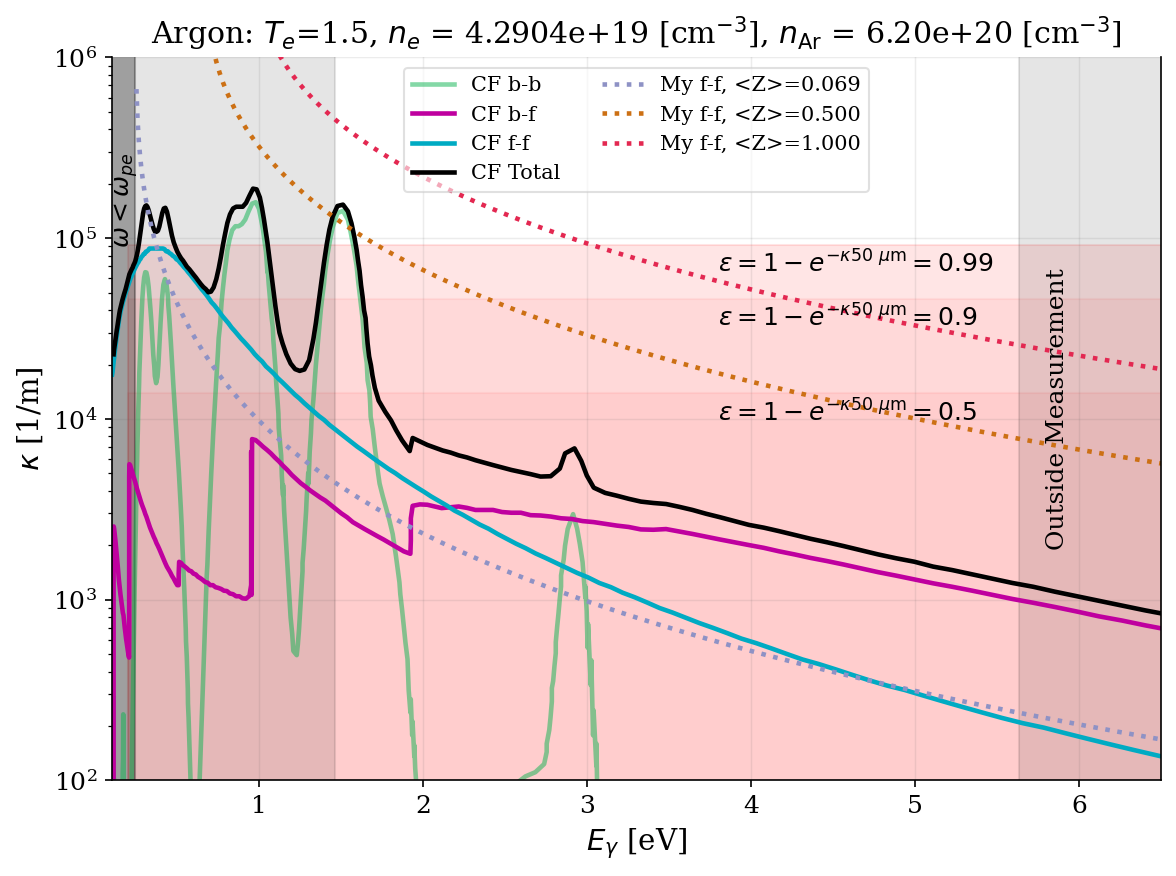

In [9]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

ax.set_title(r"Argon: $T_e$={0}, $n_e$ = {1} [cm$^{{-3}}$], $n_{{\rm Ar}}$ = {2:0.2e} [cm$^{{-3}}$]".format(Te_eV, ne_invcc, nn_invcc ))
ax.plot(bb_opacity_Eγ_eV , bb_opacity_κ_invm, label= "CF b-b", alpha=0.5 ) 
ax.plot(bf_opacity_Eγ_eV , bf_opacity_κ_invm, label= "CF b-f" ) 
ax.plot(ff_opacity_Eγ_eV , ff_opacity_κ_invm, label= "CF f-f" ) 
ax.plot(tot_opacity_Eγ_eV , tot_opacity_κ_invm, 'k', label= "CF Total" ) 

Eγ_eV_array= np.geomspace(2e-1,50, num=200) 

Zbar = 6.92e-2
ax.plot(Eγ_eV_array , get_κff_absorption(Eγ_eV_array, Zbar),':', label=f"My f-f, <Z>={Zbar:0.3f}") 
Zbar = 0.5
ax.plot(Eγ_eV_array , get_κff_absorption(Eγ_eV_array, Zbar),':', label=f"My f-f, <Z>={Zbar:0.3f}") 
Zbar = 1
ax.plot(Eγ_eV_array , get_κff_absorption(Eγ_eV_array, Zbar),':', label=f"My f-f, <Z>={Zbar:0.3f}") 


κ_0p5_50μm = -np.log(0.5)/50e-6
ax.fill_between(Eγ_eV_array, 1e-10, κ_0p5_50μm  , color='r', alpha=0.05) # trasmittance = e^(-κ L )
ax.text(3.8,0.7*κ_0p5_50μm, r"$\epsilon = 1 - e^{-\kappa 50\ \mu {\rm m}}=0.5$", rotation=0)

κ_0p1_50μm = -np.log(0.1)/50e-6
ax.fill_between(Eγ_eV_array, 1e-10, κ_0p1_50μm  , color='r', alpha=0.05) # trasmittance = e^(-κ L )
ax.text(3.8,0.7*κ_0p1_50μm, r"$\epsilon = 1 - e^{-\kappa 50\ \mu {\rm m}}=0.9$", rotation=0)

κ_0p01_50μm = -np.log(0.01)/50e-6
ax.fill_between(Eγ_eV_array, 1e-10, κ_0p01_50μm  , color='r', alpha=0.1) # trasmittance = e^(-κ L )
ax.text(3.8,0.7*κ_0p01_50μm, r"$\epsilon = 1 - e^{-\kappa 50\ \mu {\rm m}}=0.99$", rotation=0)


# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$E_\gamma$ [eV]")
ax.set_ylabel(r"$\kappa$ [1/m]")
ax.set_xlim(0.1,6.5)
ax.set_ylim(1e2,1e6)

E_pe = SMT.electron_plasma_frequency(ne_invm3)*hbar*J_to_eV
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, E_pe, color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, λ_nm_to_Eγ(850), color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), λ_nm_to_Eγ(220), 200, color='k', alpha=0.1)

ax.text(5.8,0.2e4, "Outside Measurement", rotation=90)
ax.text(0.1,1e5, r"$\omega < \omega_{pe}$", rotation=90)

# ax.set_ylim(0,1e4)
ax.legend(loc='upper center', ncol=2)
# ax.set_xscale('log')
# ax.set_xlim(1e-1,None)
plt.tight_layout()
plt.savefig("../../media/" + Ar_type_dir + "_combined_κ.png", dpi=200)

In [10]:
Eγ_to_λ_nm(1)

1239.8419843320028

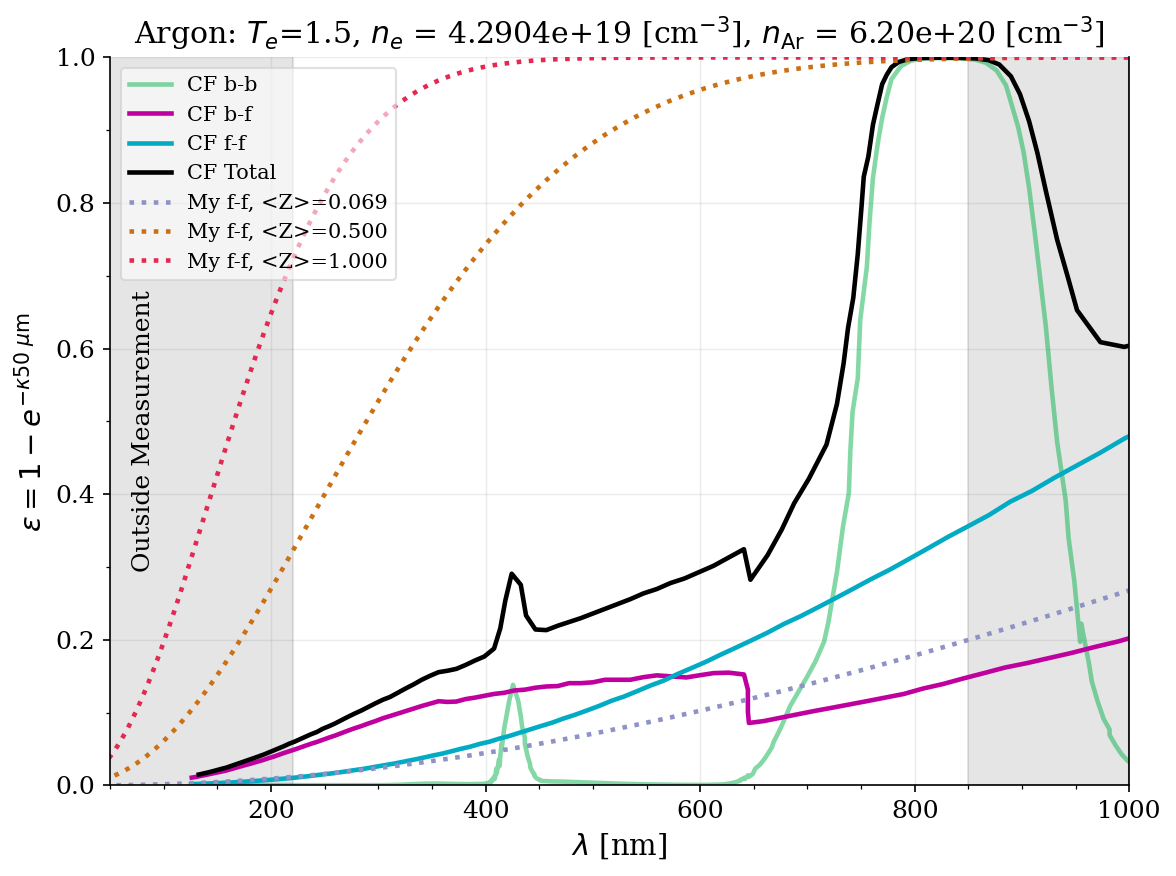

In [11]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(figsize=(8,6), dpi=150)

ax.set_title(r"Argon: $T_e$={0}, $n_e$ = {1} [cm$^{{-3}}$], $n_{{\rm Ar}}$ = {2:0.2e} [cm$^{{-3}}$]".format(Te_eV, ne_invcc, nn_invcc ))
ax.plot(Eγ_to_λ_nm(bb_opacity_Eγ_eV) , 1-np.exp(-50e-6*bb_opacity_κ_invm), label= "CF b-b", alpha=0.5 ) 
ax.plot(Eγ_to_λ_nm(bf_opacity_Eγ_eV) , 1-np.exp(-50e-6*bf_opacity_κ_invm), label= "CF b-f" ) 
ax.plot(Eγ_to_λ_nm(ff_opacity_Eγ_eV) , 1-np.exp(-50e-6*ff_opacity_κ_invm), label= "CF f-f" ) 
ax.plot(Eγ_to_λ_nm(tot_opacity_Eγ_eV) , 1-np.exp(-50e-6*tot_opacity_κ_invm), 'k', label= "CF Total" ) 

Eγ_eV_array= np.geomspace(2e-1,50, num=200) 

Zbar = 6.92e-2
ax.plot(Eγ_to_λ_nm(Eγ_eV_array) , 1-np.exp(-50e-6*get_κff_absorption(Eγ_eV_array, Zbar)),':', label=f"My f-f, <Z>={Zbar:0.3f}") 
Zbar = 0.5
ax.plot(Eγ_to_λ_nm(Eγ_eV_array) , 1-np.exp(-50e-6*get_κff_absorption(Eγ_eV_array, Zbar)),':', label=f"My f-f, <Z>={Zbar:0.3f}") 
Zbar = 1
ax.plot(Eγ_to_λ_nm(Eγ_eV_array) , 1-np.exp(-50e-6*get_κff_absorption(Eγ_eV_array, Zbar)),':', label=f"My f-f, <Z>={Zbar:0.3f}") 



E_pe = SMT.electron_plasma_frequency(ne_invm3)*hbar*J_to_eV
ax.fill_betweenx(np.linspace(0,1e8, num=2), Eγ_to_λ_nm(E_pe), 1000 , color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 850, 2000, color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, 220, color='k', alpha=0.1)

ax.text(70, 0.3, "Outside Measurement", rotation=90)
# ax.text(200, 0.3, "Outside Measurement", rotation=90)
# ax.text(0.1,1e5, r"$\omega < \omega_{pe}$", rotation=90)
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# ax.set_ylim(0,1e4)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r"$\lambda$ [nm]")
ax.set_ylabel(r"$\epsilon=1-e^{-\kappa 50\ \mu {\rm m}}$")
ax.set_xlim(50, 1000)
ax.set_ylim(0,1)

ax.legend(loc='upper left', ncol=1)
# ax.set_xscale('log')
# ax.set_xlim(1e-1,None)
plt.tight_layout()
plt.savefig("../../media/" + Ar_type_dir + "_combined_ε.png", dpi=200)

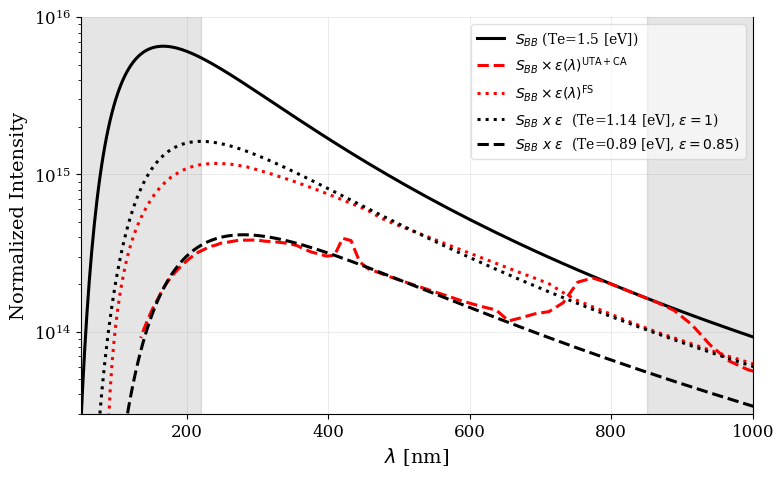

In [12]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()

ε_interp = interp1d(Eγ_to_λ_nm(tot_opacity_Eγ_eV), 1-np.exp(-50e-6*tot_opacity_κ_invm), bounds_error=False)

ε_FS_data = read_csv("../../data/CF_Collisional_Radiative/Ar_Te=Tr=1.5eV_nAr=6.2e20invcc/Emissivity_ar_1.5ev_1.5ev_6.2e20cc_01_02_FS_CL_CB_5000pts.txt", delim_whitespace=True, header=1) 
ε_FS_interp = interp1d(ε_FS_data['Eγ[eV]'], ε_FS_data['ε'], bounds_error=False, fill_value='extrapolate')


normalized_Source_function_λ = lambda Te_eV: SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K)#/np.max( SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K))
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_eV), 'k-', label=f"$S_{{BB}}$ (Te={Te_eV} [eV])")
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_eV)*ε_interp(Eγ_to_λ_nm(Eγ_eV_array)),'r--', label=r"$S_{BB} \times \epsilon(\lambda)^{\rm UTA+CA}$")
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_eV)*ε_FS_interp(Eγ_eV_array),'r:', label=r"$S_{BB} \times \epsilon(\lambda)^{\rm FS}$")

fake_ε = 1
Te_peak_new = 2.897771955e-3/(220*1e-9)*K_to_eV
normalized_Source_function_λ = lambda Te_eV: fake_ε*SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K)#/np.max( SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K))
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_peak_new), 'k:', label=f"$ S_{{BB}}\ x\ \epsilon$  (Te={Te_peak_new:0.2f} [eV], $\epsilon={fake_ε}$)")


fake_ε = 0.85
Te_peak_new = 2.897771955e-3/(280*1e-9)*K_to_eV
normalized_Source_function_λ = lambda Te_eV: fake_ε*SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K)#/np.max( SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K))
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_peak_new), 'k--', label=f"$ S_{{BB}}\ x\ \epsilon$  (Te={Te_peak_new:0.2f} [eV], $\epsilon={fake_ε}$)")


ax.set_ylim(3e13,1e16)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(50, 1000)
ax.fill_betweenx(np.linspace(0,1e20, num=2), 850, 2000, color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e20,num=2), 0, 220, color='k', alpha=0.1)


ax.set_ylabel(r"Normalized Intensity")
ax.set_xlabel(r"$\lambda$ [nm]")
ax.legend()
plt.tight_layout()
plt.savefig("../../media/Rough_uniform-plasma_Intensity.png", dpi=200)

/home/zach/plasma/ucla/core/physics.py:334: RuntimeWarning: invalid value encountered in sqrt
  l_mfp = c/ν_ω * np.sqrt(1-γ)/γ


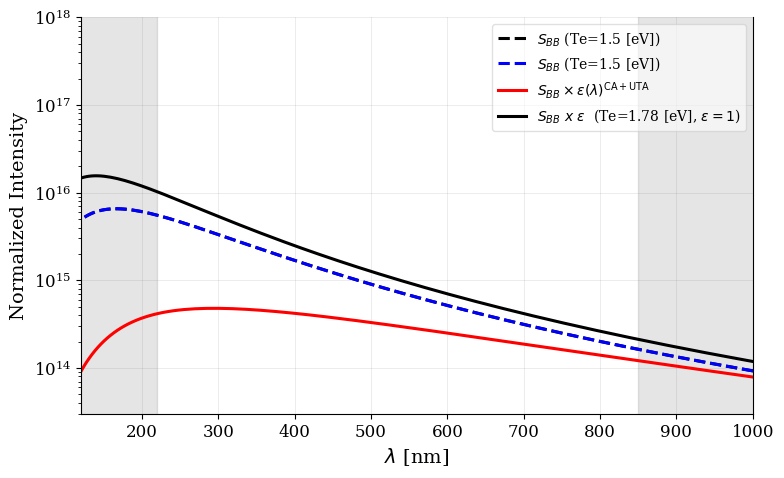

In [13]:
from scipy.interpolate import interp1d

# Te_eV = 3
def get_κff_absorption(Eγ_eV, Zbar, Te_eV):
    ω_invs = Eγ_eV*eV_to_J/hbar
    κ_invm = SMT.photon_absorption_coefficient(ω_invs, mi_kg, Zbar*nn_invm3, Zbar*nn_invm3, Ti_K, Te_K)
    return κ_invm

fig, ax = plt.subplots()

ε_interp = 1-np.exp(-50e-6*get_κff_absorption(Eγ_eV_array, 0.2, Te_eV))


normalized_Source_function_λ = lambda Te_eV: SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K)#/np.max( SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K))
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_eV), 'k--', label=f"$S_{{BB}}$ (Te={Te_eV} [eV])")
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(1.5), 'b--', label=f"$S_{{BB}}$ (Te={1.5} [eV])")
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_eV)*ε_interp,'r-', label=r"$S_{BB} \times \epsilon(\lambda)^{\rm CA+UTA}$")


Te_peak_new = 2.897771955e-3/(140*1e-9)*K_to_eV
fake_ε = 1
normalized_Source_function_λ = lambda Te_eV: fake_ε*SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K)#/np.max( SMT.photon_wavelength_density(Eγ_to_λ_nm(Eγ_eV_array)*1e-9, Te_eV*eV_to_K))
ax.plot(Eγ_to_λ_nm(Eγ_eV_array), normalized_Source_function_λ(Te_peak_new), 'k-', label=f"$ S_{{BB}}\ x\ \epsilon$  (Te={Te_peak_new:0.2f} [eV], $\epsilon={fake_ε}$)")

ax.set_ylim(3e13,1e18)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(120, 1000)
ax.fill_betweenx(np.linspace(0,1e20, num=2), 850, 2000, color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e20,num=2), 0, 220, color='k', alpha=0.1)


ax.set_ylabel(r"Normalized Intensity")
ax.set_xlabel(r"$\lambda$ [nm]")
ax.legend()
plt.tight_layout()
plt.savefig("../../media/Rough_uniform-plasma_Intensity.png", dpi=200)

In [14]:
Eγ_to_λ_nm(10)

123.98419843320029

### New Fine Structure 

In [156]:
N_dense = int(1e3)
dense_Eγ = np.linspace(0.1, 10, num=N_dense)
dx = dense_Eγ[1]-dense_Eγ[0]

In [157]:
from scipy.interpolate import interp1d

fs_1p5eV_data = read_csv("../../data/CF_Collisional_Radiative/Ar_Te=Tr=1.5eV_nAr=6.2e20invcc/opac_ar_1.5ev_1.5ev_6.2e20cc_01_02_FS_LINES_5000pts_log_zoom_LABELS.txt", delim_whitespace=True, header=0 )
fs_1p5eV_data_total = read_csv("../../data/CF_Collisional_Radiative/Ar_Te=Tr=1.5eV_nAr=6.2e20invcc/opac_ar_1.5ev_1.5ev_6.2e20cc_01_02_FS_LINES_5000pts_log_zoom_LABELS_total.txt", delim_whitespace=True, header=0 )
fs_1p5eV_Eγ = fs_1p5eV_data['E_γ[eV]']
fs_1p5eV_κ = fs_1p5eV_data['opacity[cm^2/g]']*ρi_kginvm3 

fs_1p5eV_Eγ_total = fs_1p5eV_data_total['E_γ[eV]']
fs_1p5eV_κ_total = fs_1p5eV_data_total['opacity[cm^2/g]']*ρi_kginvm3 

fs_1p5eV_κ_interp = interp1d(fs_1p5eV_Eγ, fs_1p5eV_κ, bounds_error=False, fill_value=(0,0))
fs_1p5eV_κ_interped = fs_1p5eV_κ_interp(dense_Eγ)

(100.0, 10000000.0)

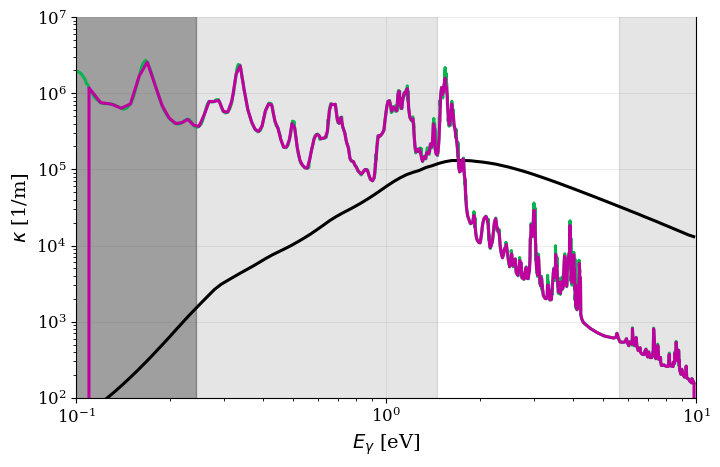

In [158]:
fig, ax = plt.subplots()

ax.plot(fs_1p5eV_Eγ, fs_1p5eV_κ)
ax.plot(fs_1p5eV_Eγ_total, fs_1p5eV_κ_total, color='k')
ax.plot(dense_Eγ, fs_1p5eV_κ_interped)


ax.set_yscale('log')
ax.set_xscale('log')
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, E_pe, color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, λ_nm_to_Eγ(850), color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), λ_nm_to_Eγ(220), 200, color='k', alpha=0.1)

ax.set_xlabel(r"$E_\gamma$ [eV]")
ax.set_ylabel(r"$\kappa$ [1/m]")
ax.set_xlim(0.1,10)
ax.set_ylim(1e2,1e7)

(100.0, 10000000.0)

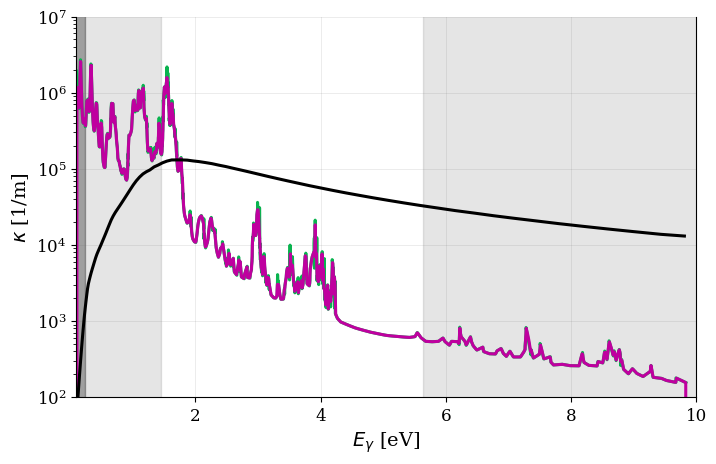

In [159]:
fig, ax = plt.subplots()

ax.plot(fs_1p5eV_Eγ, fs_1p5eV_κ)
ax.plot(dense_Eγ, fs_1p5eV_κ_interped)
ax.plot(fs_1p5eV_Eγ_total, fs_1p5eV_κ_total, color='k')


ax.set_yscale('log')
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, E_pe, color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, λ_nm_to_Eγ(850), color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), λ_nm_to_Eγ(220), 200, color='k', alpha=0.1)

ax.set_xlabel(r"$E_\gamma$ [eV]")
ax.set_ylabel(r"$\kappa$ [1/m]")
ax.set_xlim(0.1,10)
ax.set_ylim(1e2,1e7)


In [160]:
N_extended = 10*N_dense
L_extended = (N_extended-1)*dx
dense_Eγ_extended = np.linspace(-L_extended/2, L_extended/2, num=N_extended)
dense_Eγ_extended[1]-dense_Eγ_extended[0], dx

(0.00990990990990781, 0.009909909909909906)

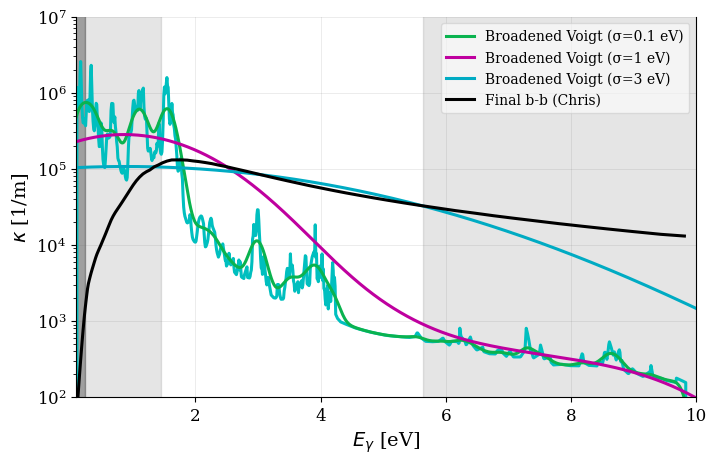

In [162]:
from scipy.special import voigt_profile
from scipy.signal import convolve

X1, X2 = np.meshgrid(dense_Eγ_extended, dense_Eγ_extended, indexing='ij')

κ_sharp =  fs_1p5eV_κ_interped 
κ_smoothed = lambda σ: np.sum(fs_1p5eV_κ_interp(X2)*voigt_profile(X1-X2, σ, 0)*dx, axis=1)

fig, ax = plt.subplots()

ax.plot(dense_Eγ, κ_sharp, color='c')
ax.plot(dense_Eγ_extended, κ_smoothed(0.1), label="Broadened Voigt (σ=0.1 eV)")
ax.plot(dense_Eγ_extended, κ_smoothed(1) , label="Broadened Voigt (σ=1 eV)")
ax.plot(dense_Eγ_extended, κ_smoothed(3) , label="Broadened Voigt (σ=3 eV)")
ax.plot(fs_1p5eV_Eγ_total, fs_1p5eV_κ_total, color='k', label='Final b-b (Chris)')


ax.set_yscale('log')
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, E_pe, color='k', alpha=0.3)
ax.fill_betweenx(np.linspace(0,1e8, num=2), 0, λ_nm_to_Eγ(850), color='k', alpha=0.1)
ax.fill_betweenx(np.linspace(0,1e8, num=2), λ_nm_to_Eγ(220), 200, color='k', alpha=0.1)

ax.set_xlabel(r"$E_\gamma$ [eV]")
ax.set_ylabel(r"$\kappa$ [1/m]")
ax.set_xlim(0.1,10)
ax.set_ylim(1e2,1e7)
ax.legend()
